In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [31]:
# gather all features we have downloaded thus far - make sure they all have zipcode data
prison = pd.read_pickle('../data/prison_binary.pkl').drop('state', 1).rename(columns = {'zip': 'zipcode'})
jail = pd.read_pickle('../data/jail_binary.pkl').rename(columns = {'zip': 'zipcode'})
demographics = pd.read_pickle('../data/cleaned_demographic_features.pkl').drop(['GEO.id', 'GEO.display-label'], 1)
demographics = demographics.rename(columns = {'GEO.id2': 'zipcode'})
bus_patterns = pd.read_pickle('../data/business_patterns.pkl').drop('Geographic area name', 1)
bus_patterns = bus_patterns.rename(columns = {'Number of establishments':'n_establishments'})
income = pd.read_pickle('../data/medianIncome.pkl')
yelp = pd.read_pickle('../data/yelpexport.pkl')
yelp['zipcode'] = yelp.zipcode.astype('str')

In [32]:
prison.head(3)

,zipcode,prison
0,35034,1
1,36089,1
2,35023,1


In [33]:
jail.head(3)

,zipcode,jail
0,36067,1
1,36507,1
2,36016,1


In [34]:
demographics.head(3)

,zipcode,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056
1,00601,18570,12.8,16.2,13.9,11.7,13.3,13.1,10.2,5.7,3.1,48.9,6.6,8.5,6.9,5.4,6.3,6.3,4.9,2.7,1.3,51.1,6.3,7.7,7,6.3,6.9,6.8,5.3,2.9,1.8,93.1,3.1,0.4,0,0,99.5,77.8,5.1,2.6,20.3,9.6,20.3,10.2,3.3,10.1,5.5,39.5,29,84.3,15.7,2.9,0.5,2.84,3.27,7744,2.87
2,00602,41520,11.5,15.2,13.5,12.9,14.6,14,10.1,5.7,2.3,49.1,5.9,7.7,6.7,6.4,7,6.8,4.9,2.6,1.1,50.9,5.6,7.5,6.8,6.5,7.6,7.2,5.2,3.1,1.3,86.7,5.3,0.3,0.1,0,99.4,77.6,5.1,2.1,17.4,8,20.5,10.5,3,10,4.9,37.6,25.9,83,17,2.6,1.3,2.76,3.20,18073,2.62
3,00603,54689,12.2,14.2,13,13,12.7,12.6,12,7,3.3,48.6,6.4,7.3,6.5,6.4,6,5.8,5.6,3.2,1.4,51.4,5.8,7,6.5,6.6,6.6,6.7,6.4,3.7,2.1,82.9,7.6,0.3,0.2,0,98.5,71.1,4.7,1.7,22,10.9,26.4,12.7,4.1,13.8,6.8,34,31.1,82.5,17.5,3.6,1.5,2.53,3.06,25653,2.51


In [35]:
bus_patterns.head(3)

,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,zipcode
1,448,9185,70693,314508,01001
2,570,15633,82069,351589,01002
3,16,168,1297,5761,01003


In [38]:
income.head(3)

,zipcode,median_income
0,00601,13318
1,00602,14947
2,00603,14437


In [39]:
jail.shape, prison.shape, demographics.shape, bus_patterns.shape, income.shape, yelp.shape

((2870, 2), (975, 2), (33120, 57), (31255, 5), (33120, 2), (905, 19))

In [42]:
# merge all features into single data frame
all_features = demographics.merge(bus_patterns, how='inner', on='zipcode').fillna(0)
all_features = all_features.merge(prison, how='left', on='zipcode').fillna(0)
all_features = all_features.merge(jail, how='left', on='zipcode').fillna(0)
# where median income data is missing, fill with median income across all zipcodes
med = np.median(income.median_income.dropna().values)
all_features = all_features.merge(income, how='left', on='zipcode')
all_features.median_income.fillna(med, inplace=True)

In [43]:
all_features.head(300)

,zipcode,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,prison,jail,median_income
0,01001,16769,9.3,11.1,10.7,11.3,14.4,14.9,11.8,7.3,9.0,46.8,4.8,5.5,5.3,5.8,7.0,7.3,5.4,3.0,2.8,53.2,4.6,5.5,5.5,5.5,7.5,7.7,6.4,4.4,6.2,93.6,1.8,0.2,2.1,0.0,3.3,57.9,4.2,1.9,9.8,4.8,35.1,13.7,4.1,21.3,11.4,24.6,32.2,95.5,4.5,2.1,0.7,2.23,2.91,7557,1.83,448,9185,70693,314508,0,0,59453
1,01002,29049,6.7,17.8,33.8,7.4,8.4,10.7,7.7,4.1,3.4,48.0,3.5,8.1,17.6,3.6,3.8,4.8,3.5,1.8,1.1,52.0,3.3,9.6,16.2,3.8,4.6,5.9,4.2,2.3,2.2,77.8,5.0,0.3,10.2,0.0,7.9,49.8,2.7,1.3,10.1,6.4,26.8,10.8,2.3,16.0,7.2,23.7,22.1,95.4,4.6,1.8,0.7,2.44,2.87,10388,2.39,570,15633,82069,351589,0,0,54395
2,01003,10372,0.0,45.7,53.8,0.3,0.0,0.1,0.0,0.0,0.0,51.3,0.0,22.1,28.9,0.2,0.0,0.1,0.0,0.0,0.0,48.7,0.0,23.5,25.0,0.1,0.0,0.0,0.0,0.0,0.0,76.9,6.1,0.1,11.5,0.0,5.1,40.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,20.0,0.0,100.0,0.0,0.0,0.0,3.20,3.50,5,3.20,16,168,1297,5761,0,0,46911
3,01005,5079,11.1,16.8,9.7,10.8,16.0,16.9,9.9,4.5,4.2,50.6,5.7,9.5,5.0,5.1,7.8,8.4,5.5,2.3,1.3,49.4,5.5,7.4,4.7,5.6,8.2,8.5,4.5,2.1,2.8,96.3,1.2,0.2,0.5,0.0,1.8,70.1,5.1,2.7,10.0,5.6,24.0,11.7,3.6,12.3,7.2,34.3,25.9,93.2,6.8,1.3,1.7,2.61,3.09,2044,2.18,96,926,5698,24382,0,0,74167
4,01007,14649,12.8,14.5,9.1,11.7,17.8,17.6,9.7,4.3,2.5,48.7,6.6,7.5,4.7,5.5,8.3,8.6,4.7,1.8,1.0,51.3,6.2,7.0,4.4,6.3,9.4,9.0,4.9,2.4,1.5,93.8,1.4,0.1,2.1,0.1,2.6,71.5,3.5,1.9,10.2,6.5,21.7,9.2,2.3,12.6,5.8,36.6,20.4,95.8,4.2,0.8,1.1,2.62,3.06,5839,2.16,238,1740,10479,47376,0,0,75502
5,01008,1263,9.7,11.8,9.7,10.2,16.2,18.6,15.6,5.2,2.9,51.7,5.0,6.9,4.9,5.3,7.2,9.9,8.3,2.4,1.7,48.3,4.7,4.9,4.8,4.9,9.0,8.7,7.3,2.7,1.3,98.4,0.3,0.2,0.3,0.0,1.3,72.8,3.6,1.0,6.4,2.8,20.9,13.3,3.4,7.6,4.2,30.0,25.4,85.8,14.2,0.0,1.7,2.51,2.90,586,2.18,21,370,751,2899,0,0,78563
6,01009,741,10.5,13.1,13.0,14.3,15.7,14.6,10.7,2.8,5.3,52.1,6.0,8.1,6.8,7.9,7.0,7.0,6.0,1.5,1.7,47.9,4.5,5.0,6.2,6.3,8.6,7.5,4.9,1.4,3.5,96.1,0.5,0.1,0.4,0.0,2.0,61.6,4.8,1.9,15.2,8.9,30.2,15.6,3.2,14.6,7.0,28.9,22.2,92.4,7.6,1.5,0.3,2.35,2.93,341,2.29,15,130,1149,4965,0,0,46625
7,01010,3609,10.0,13.7,7.7,10.9,18.4,18.4,12.0,5.5,3.3,49.6,5.0,7.3,4.1,5.4,8.8,9.2,6.1,2.6,1.1,50.4,5.1,6.4,3.6,5.5,9.6,9.3,5.9,2.9,2.2,96.8,0.8,0.3,0.5,0.1,2.2,70.0,4.1,2.4,6.3,3.1,23.7,10.5,3.0,13.2,7.7,30.9,26.7,89.4,10.6,0.4,1.6,2.53,2.98,1598,1.76,75,335,2540,12366,0,0,78380
8,01011,1370,9.5,13.7,8.6,10.1,17.7,19.7,11.2,6.0,3.6,51.5,4.5,7.5,5.2,5.4,9.0,9.5,6.0,3.2,1.3,48.5,5.1,6.1,3.5,4.6,8.7,10.2,5.2,2.8,2.3,98.2,0.0,0.0,0.8,0.0,0.9,68.0,6.1,3.0,9.3,4.8,25.9,13.6,3.2,12.3,4.6,28.4,24.5,85.0,15.0,0.8,2.0,2.45,2.96,659,2.24,17,47,251,1432,0,0,55795
9,01012,661,8.1,12.8,9.1,9.8,15.4,21.3,14.0,4.8,4.5,50.5,3.9,7.1,5.6,4.4,6.5,11.5,6.9,2.3,2.3,49.5,4.2,5.6,3.5,5.5,9.0,9.8,7.1,2.6,2.3,97.4,0.3,0.2,0.8,0.0,1.5,65.4,6.4,5.3,8.5,3.5,26.9,13.4,1.8,13.4,4.2,27.9,21.9,82.5,17.5,0.6,0.3,2.34,2.84,343,2.51,13,84,436,2189,0,0,49821


In [44]:
zipCodeStrings = all_features.zipcode
all_features = all_features.astype('float')

/Users/princess_eliza/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


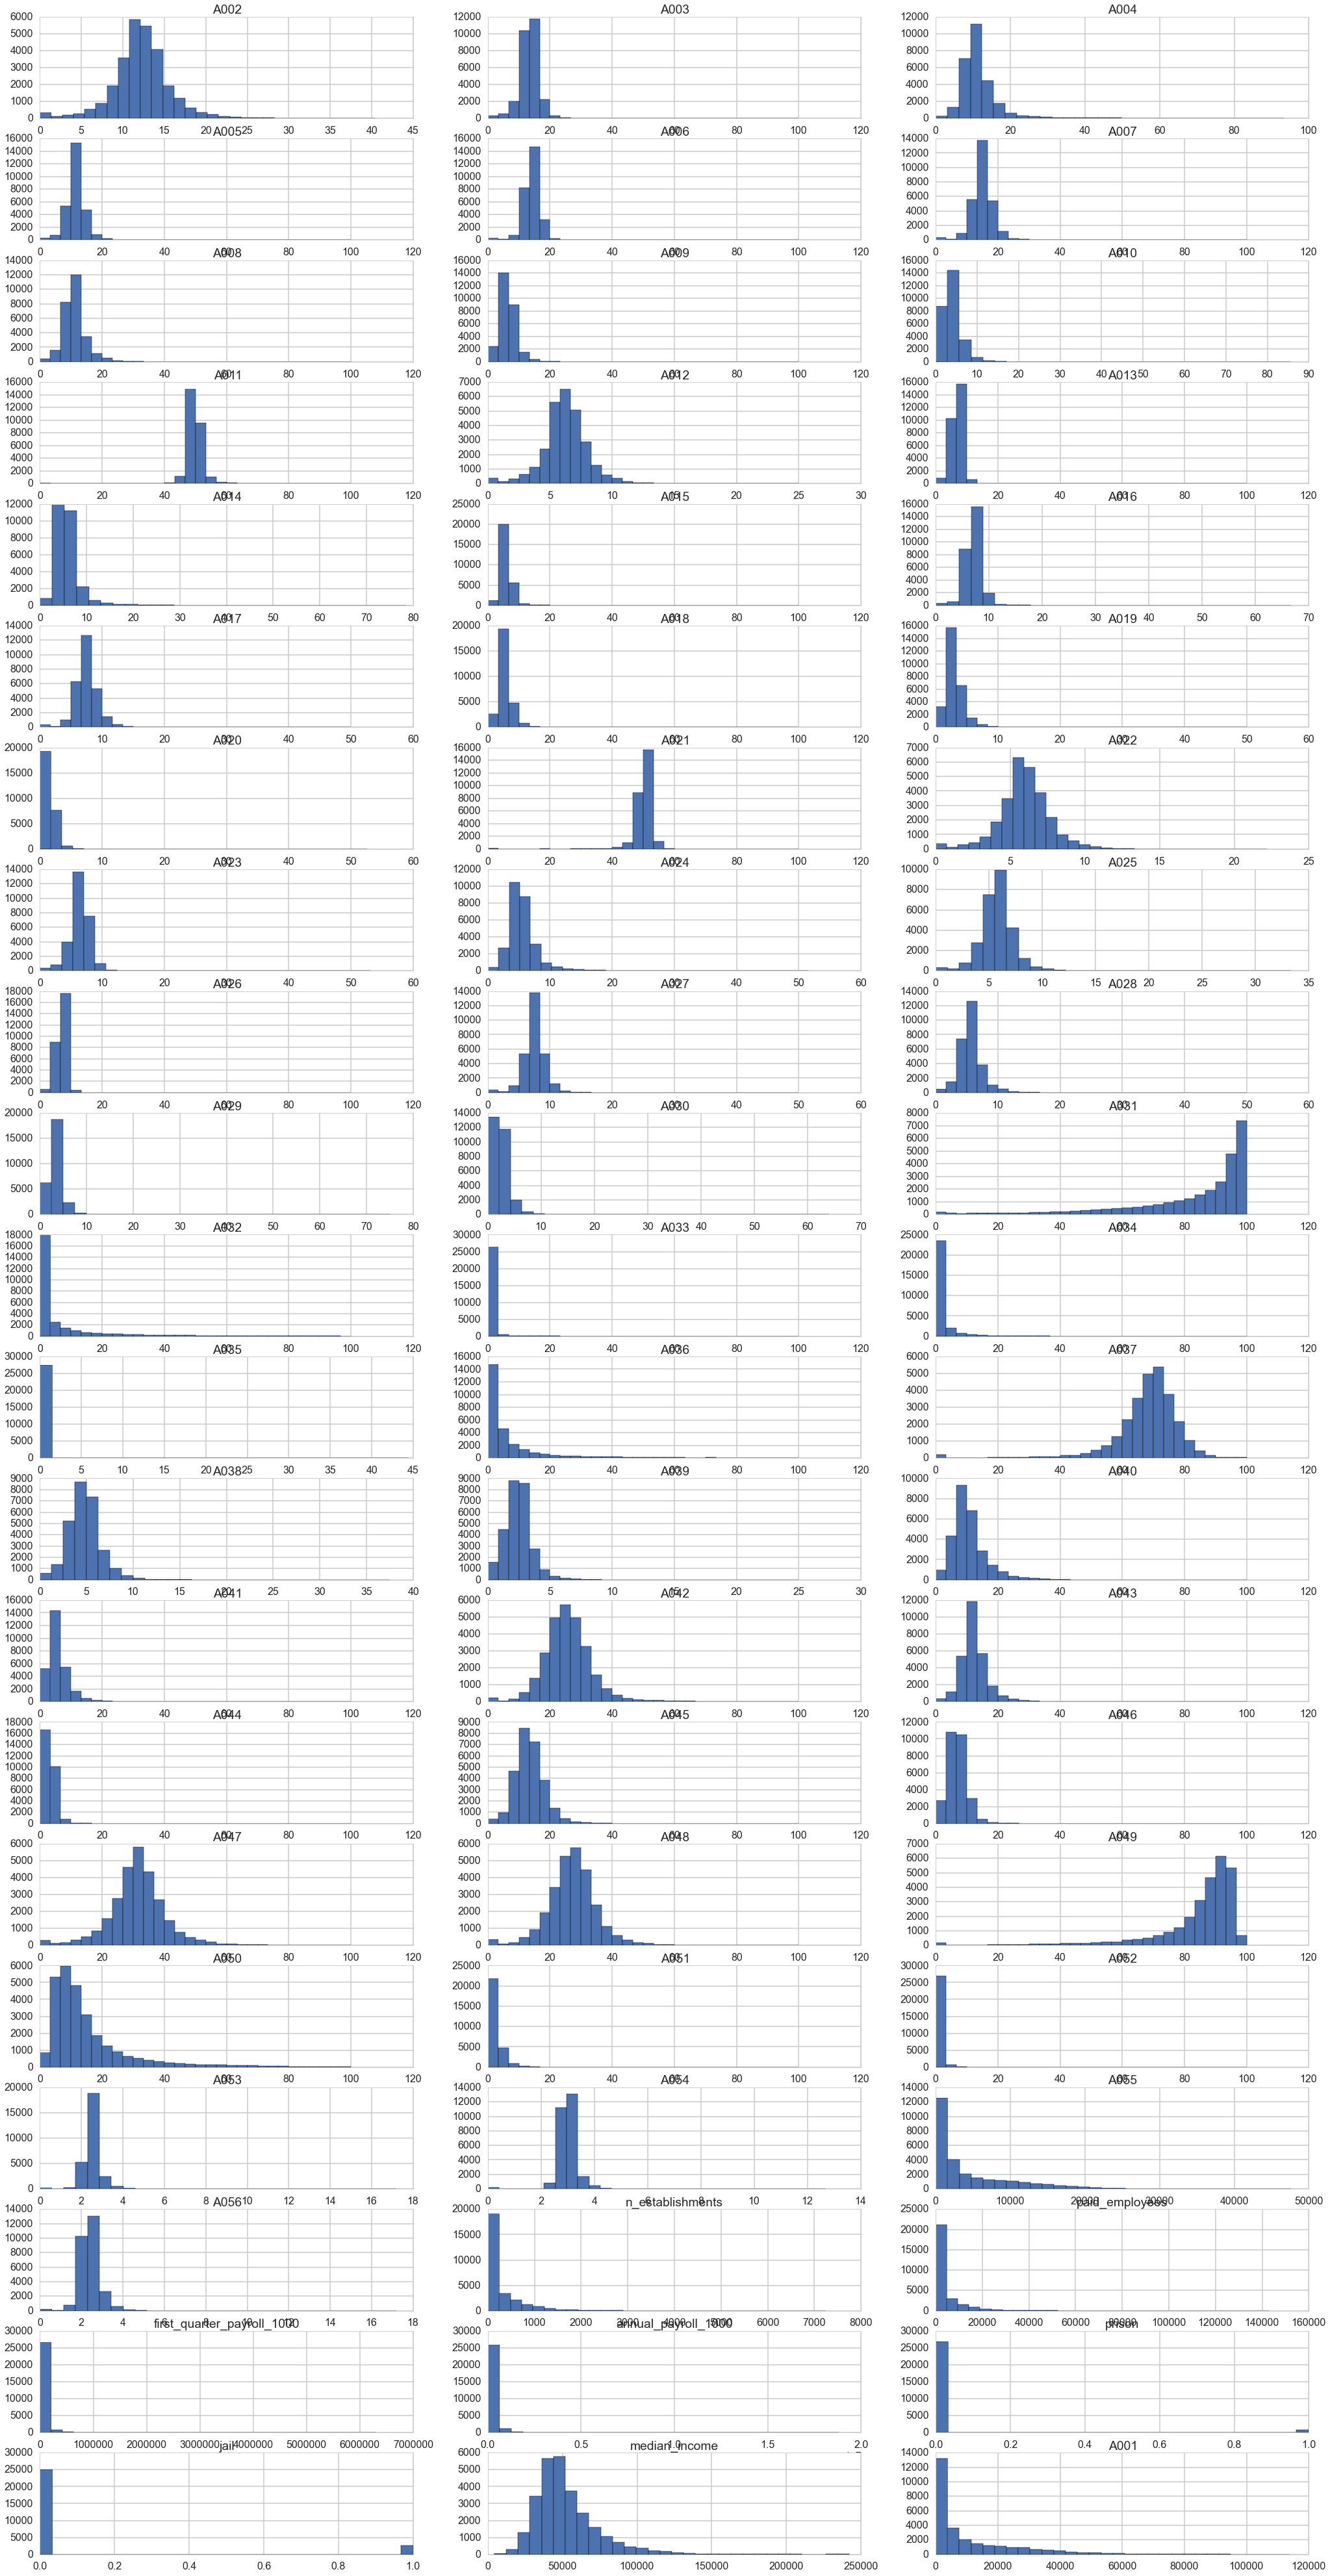

In [45]:
features = all_features.columns[1:]
if len(features)%3 == 0 :
    nROW = len(features)/3
else :
    nROW = np.ceil(len(features)/3.).astype(int)
nCOL = 3

f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))

for i in xrange(len(features)):
    plt.subplot(nROW,nCOL,i)
    ax = all_features[features[i]].hist(bins = 30)
    ax.set_title(features[i])

### List of features that are right skewed:
A20
A30
A32
A36
A34
A50
A51
A55
n_establishments
paid_employees
### left skewed:
A31
A49

In [46]:
all_features.shape

(27653, 64)

In [47]:
all_features.head(3)

,zipcode,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,prison,jail,median_income
0,1001,16769,9.3,11.1,10.7,11.3,14.4,14.9,11.8,7.3,9.0,46.8,4.8,5.5,5.3,5.8,7.0,7.3,5.4,3.0,2.8,53.2,4.6,5.5,5.5,5.5,7.5,7.7,6.4,4.4,6.2,93.6,1.8,0.2,2.1,0,3.3,57.9,4.2,1.9,9.8,4.8,35.1,13.7,4.1,21.3,11.4,24.6,32.2,95.5,4.5,2.1,0.7,2.23,2.91,7557,1.83,448,9185,70693,314508,0,0,59453
1,1002,29049,6.7,17.8,33.8,7.4,8.4,10.7,7.7,4.1,3.4,48.0,3.5,8.1,17.6,3.6,3.8,4.8,3.5,1.8,1.1,52.0,3.3,9.6,16.2,3.8,4.6,5.9,4.2,2.3,2.2,77.8,5.0,0.3,10.2,0,7.9,49.8,2.7,1.3,10.1,6.4,26.8,10.8,2.3,16.0,7.2,23.7,22.1,95.4,4.6,1.8,0.7,2.44,2.87,10388,2.39,570,15633,82069,351589,0,0,54395
2,1003,10372,0.0,45.7,53.8,0.3,0.0,0.1,0.0,0.0,0.0,51.3,0.0,22.1,28.9,0.2,0.0,0.1,0.0,0.0,0.0,48.7,0.0,23.5,25.0,0.1,0.0,0.0,0.0,0.0,0.0,76.9,6.1,0.1,11.5,0,5.1,40.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,20.0,0.0,100.0,0.0,0.0,0.0,3.20,3.50,5,3.20,16,168,1297,5761,0,0,46911


In [48]:
from sklearn.cross_validation import train_test_split
# split into training and test sets
itrain, itest = train_test_split(xrange(all_features.shape[0]), train_size=0.8)

mask=np.ones(all_features.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

print 'samples in training set = %s \nsamples in test set = %s'%(mask.sum(), mask.shape[0] - mask.sum())

samples in training set = 22122 
samples in test set = 5531


## Standardize all features except binary ones - don't transform

In [49]:
from sklearn.preprocessing import StandardScaler

all_features_stand = all_features.copy()

# standardize all but binary features (i.e indicator variables)
stand_columns = all_features.columns[1:-3].values.tolist() + [all_features.columns[-1]]

train_raw = all_features[mask]

# initialize standardizer on training set
standardizer = StandardScaler().fit(train_raw[stand_columns])
# standardize all data
stand_data = pd.DataFrame(columns=stand_columns, data=standardizer.transform(all_features[stand_columns]))

# drop old non-standardized columns from dataframe
for col in stand_columns:
    all_features_stand = all_features_stand.drop(col, 1)

# merge dftouse with new df that has standardized data
all_features_stand = all_features_stand.merge(stand_data, how='outer', left_index=True, right_index=True)
all_features_stand['zipcode'] = zipCodeStrings

In [51]:
all_features_stand[mask].to_pickle('../data/train_all_features_norm.pkl')
all_features_stand[~mask].to_pickle('../data/test_all_features_norm.pkl')

In [52]:
all_features_stand.head(3)

,zipcode,prison,jail,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,median_income
0,01001,0,0,0.401771,-0.843614,-0.573241,-0.169757,-0.115210,0.098337,-0.020731,0.163196,0.297759,2.019330,-0.660334,-0.786445,-0.639994,-0.196468,-0.048473,-0.047686,-0.096219,-0.050374,-0.023476,1.215640,0.726129,-0.770605,-0.455103,-0.053032,-0.167484,0.284721,0.116799,0.384160,0.666973,2.288059,0.533192,-0.392888,-0.177900,-0.007998,-0.1338,-0.365594,-0.895432,-0.318163,-0.462593,-0.168991,-0.298673,1.128814,0.269801,0.443162,1.608224,1.451899,-0.745985,0.589333,0.759793,-0.798733,-0.133394,-0.545865,-0.646320,-0.224610,0.491950,-1.113336,0.457355,0.726723,0.224357,0.313082,0.311767
1,01002,0,0,1.262073,-1.596605,1.065844,3.677098,-1.368908,-2.014642,-1.241940,-0.864342,-0.805365,-0.236056,-0.398845,-1.491467,0.507170,2.914331,-1.157126,-1.865632,-1.393197,-0.881597,-0.795230,-0.416354,0.464706,-1.505464,1.425508,3.913518,-1.255218,-1.495291,-0.868788,-0.718460,-0.732778,-0.153921,-0.231833,-0.190341,-0.163576,1.546941,-0.1338,-0.063702,-1.618728,-1.111217,-0.993992,-0.116591,0.173016,0.119736,-0.326584,-0.502607,0.525573,0.099504,-0.842277,-0.635336,0.752985,-0.791182,-0.252747,-0.545865,-0.165614,-0.325396,0.980870,-0.030453,0.759042,1.600327,0.308209,0.391356,0.080165
2,01003,0,0,-0.046385,-3.537006,7.891288,7.007708,-3.651281,-4.972814,-4.324039,-2.794109,-2.218743,-1.605397,0.320250,-3.389604,6.684205,5.772219,-2.870499,-4.024443,-3.831516,-2.412798,-1.952862,-1.472351,-0.254208,-3.370876,7.801235,7.175727,-3.622640,-4.318760,-4.099324,-2.823461,-2.265838,-1.497010,-0.275410,-0.120716,-0.192224,1.796499,-0.1338,-0.247462,-2.493828,-2.538713,-2.145355,-1.880711,-1.713741,-0.706979,1.565395,-1.711091,-2.742806,-2.218889,-1.238141,-3.315058,1.066146,-1.138535,-0.968861,-1.104695,1.574083,1.261990,-0.812297,1.535859,-0.610913,-0.494940,-0.287158,-0.338650,-0.262523


## Standardize all features but binary AND log transform

In [53]:
# *** I didn't exponentiate the right-skeed columns, but that would be easy enough to try
all_features_stand_trans = all_features.copy()

right_skewed_columns = ['A020', 'A030', 'A032', 'A036', 'A034', 'A050', 'A051', 'A055', 'n_establishments', 'paid_employees']
left_skewed_columns = ['A31', 'A49']

# log transform all right_skewed columns (np.log1p does natural log of 1 plus input: ln(1 + x)) this avoids
# getting negative infinity when x = 0
log_features = all_features_stand_trans[right_skewed_columns].values.T

for i in xrange(log_features.shape[0]):
    log_features[i] =  np.log1p(log_features[i])
    
log_features_df = pd.DataFrame(log_features.T, columns = right_skewed_columns)

# drop right-skewed columns from dataframe
for col in right_skewed_columns:
    all_features_stand_trans = all_features_stand_trans.drop(col, 1)
    
# merge with new df that has log of right-skewed data
all_features_stand_trans = all_features_stand_trans.merge(log_features_df, how='outer', left_index=True, right_index=True)

# standardize all but binary features (i.e indicator variables)
stand_columns = all_features.columns[1:-3].values.tolist() + [all_features.columns[-1]]

train_raw = all_features_stand_trans[mask]

# initialize standardizer on training set
standardizer = StandardScaler().fit(train_raw[stand_columns])
# standardize all data
stand_data = pd.DataFrame(columns=stand_columns, data=standardizer.transform(all_features_stand_trans[stand_columns]))

# drop old non-standardized columns from dataframe
for col in stand_columns:
    all_features_stand_trans = all_features_stand_trans.drop(col, 1)

# merge dftouse with new df that has standardized data
all_features_stand_trans = all_features_stand_trans.merge(stand_data, how='outer', left_index=True, right_index=True)
all_features_stand_trans['zipcode'] = zipCodeStrings

In [54]:
all_features_stand_trans[mask].to_pickle('../data/train_all_features_norm_and_transform.pkl')
all_features_stand_trans[~mask].to_pickle('../data/test_all_features_norm_and_transform.pkl')

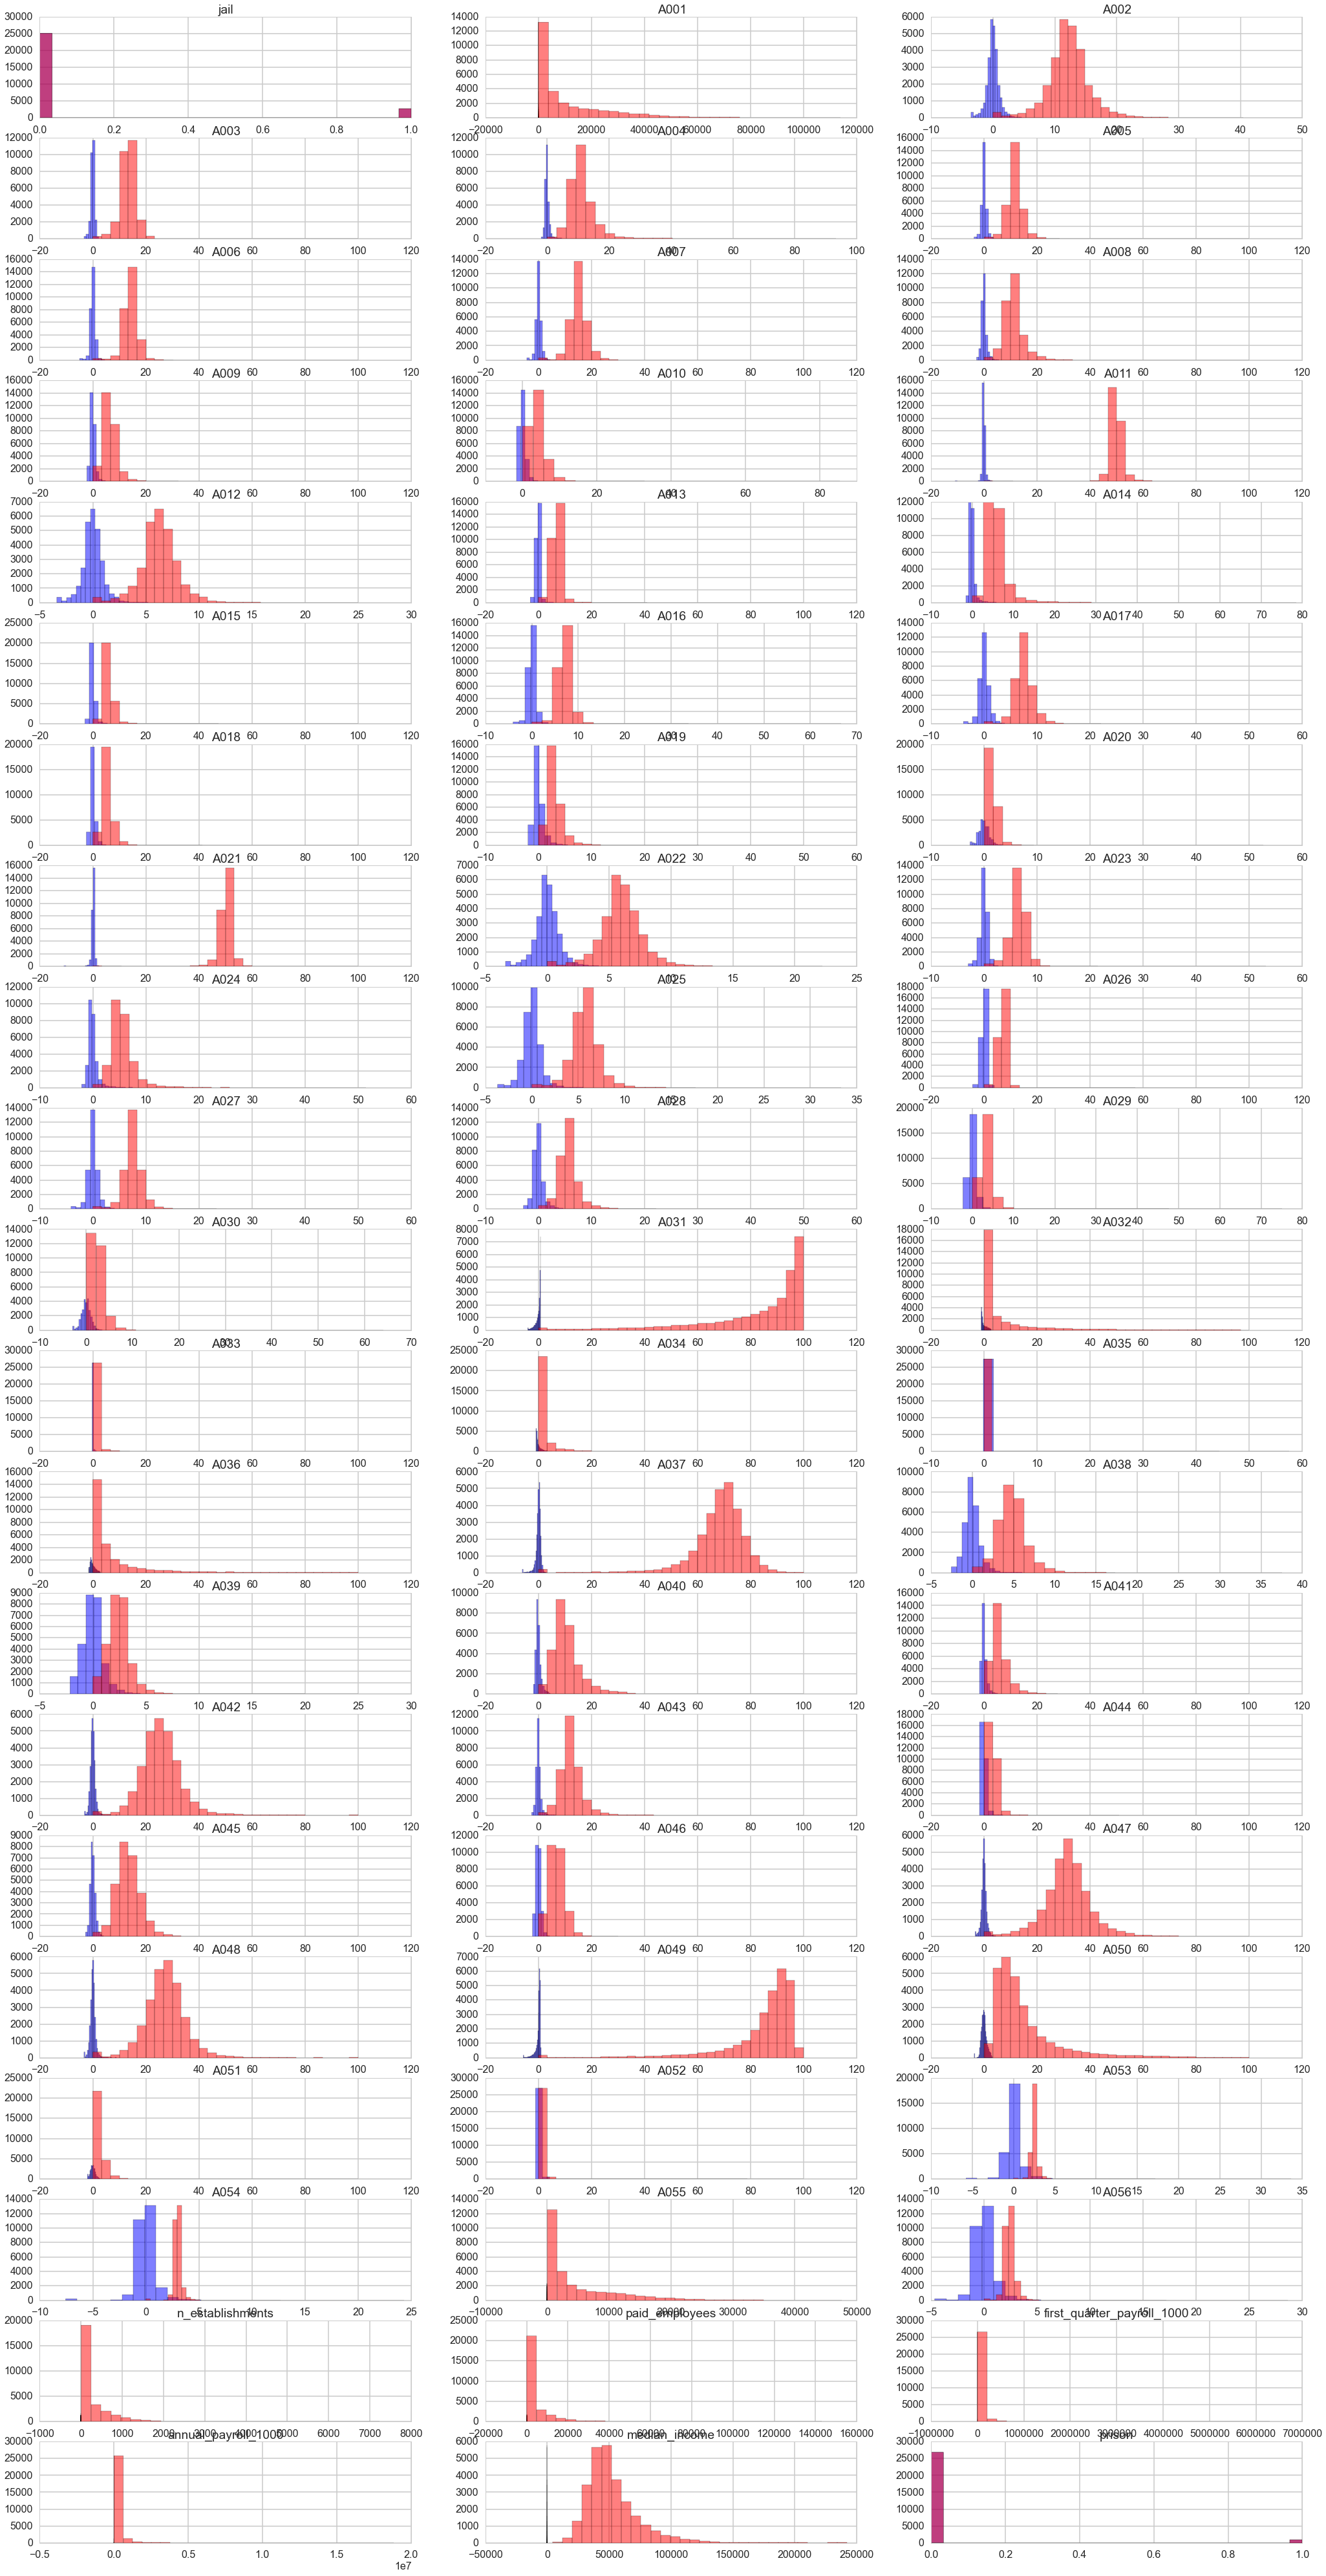

In [55]:
features_st = all_features_stand_trans.columns[1:]
if len(features_st)%3 == 0 :
    nROW = len(features_st)/3
else :
    nROW = np.ceil(len(features_st)/3.).astype(int)
nCOL = 3

f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))

for i in xrange(len(features_st)):
    plt.subplot(nROW,nCOL,i)
    ax = all_features_stand_trans[features_st[i]].hist(bins = 30, color='b', alpha=.5)
    # uncomment line below to see old features (red) vs. new (blue)
    all_features[features_st[i]].hist(bins = 30, color='r', alpha=.5)
    ax.set_title(features_st[i])

In [45]:
# all_features_normalized = pd.DataFrame(all_features_normalized, columns = all_features.columns[1:])
# all_features_normalized['zipcode'] = zipCodeStrings
# all_features_normalized.head(3)

,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,prison,jail,median_income,zipcode
0,0.403822,-0.839925,-0.577200,-0.168204,-0.114910,0.097627,-0.022710,0.164482,0.297415,1.855374,-0.654254,-0.783044,-0.641046,-0.195054,-0.049217,-0.050336,-0.098035,-0.050738,-0.022365,1.082934,0.719438,-0.767238,-0.457822,-0.048472,-0.167051,0.288460,0.114242,0.384865,0.639734,2.118527,0.535081,-0.394929,-0.177156,-0.011208,-0.13138,-0.366799,-0.888653,-0.313466,-0.455594,-0.169235,-0.295995,1.116199,0.259922,0.434214,1.593216,1.397376,-0.743050,0.584263,0.759381,-0.798737,-0.134993,-0.549322,-0.651977,-0.223378,0.495932,-1.124265,0.463735,0.737979,0.231006,0.318245,-0.172158,-0.323992,0.332304,01001
1,1.261860,-1.594272,1.084305,3.638466,-1.346952,-2.015987,-1.228271,-0.871073,-0.804575,-0.223704,-0.396719,-1.489846,0.510741,2.836251,-1.107246,-1.880773,-1.383069,-0.897923,-0.802669,-0.377333,0.461899,-1.503218,1.457233,3.958870,-1.254782,-1.507307,-0.860163,-0.722090,-0.705649,-0.149133,-0.228580,-0.192467,-0.162902,1.520559,-0.13138,-0.062326,-1.609325,-1.104775,-0.981585,-0.116915,0.173738,0.114255,-0.327087,-0.496995,0.519232,0.092856,-0.839470,-0.632176,0.752600,-0.791203,-0.255063,-0.549322,-0.163923,-0.324466,0.984798,-0.027929,0.766968,1.620780,0.316380,0.397244,-0.172158,-0.323992,0.109920,01002
2,-0.043154,-3.538166,8.003111,6.934284,-3.589901,-4.975048,-4.270877,-2.815896,-2.216499,-1.486001,0.311503,-3.392777,6.712670,5.621108,-2.742381,-4.054417,-3.798934,-2.458525,-1.973126,-1.322211,-0.246334,-3.371474,7.949734,7.254629,-3.622197,-4.355765,-4.054045,-2.835367,-2.179163,-1.396346,-0.272079,-0.122871,-0.191410,1.766398,-0.13138,-0.247657,-2.481250,-2.529132,-2.121233,-1.878365,-1.705193,-0.706614,1.535146,-1.686872,-2.722984,-2.143463,-1.235864,-3.293888,1.064512,-1.137736,-0.975481,-1.112115,1.602369,1.267669,-0.808171,1.557843,-0.610010,-0.496545,-0.289793,-0.339523,-0.172158,-0.323992,-2.281652,01003


In [46]:
# all_features_normalized.to_pickle('data/all_features_norm_not_transformed.pkl')